# **Сlassification of comments into positive and negative**

In [1]:
TF_USE_LEGACY_KERAS=1

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler



#transformers
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
from transformers import AutoModel
import transformers
from transformers import AutoTokenizer, TFAutoModel
from datasets import load_dataset
from datasets import Dataset
from transformers import TFAutoModelForSequenceClassification


#keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam



#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

# import seaborn as sns

# # Set the Seaborn style
# sns.set_style("whitegrid")
# sns.despine()
# plt.style.use("seaborn-whitegrid")
# plt.rc("figure", autolayout=True)
# plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# load data
data_reviews = pd.read_csv("d:\Project\SMART_buisness_test_task\Tasks\Task3\Desktop\dataset\order_reviews.csv")
data_order = pd.read_csv("d:\Project\SMART_buisness_test_task\Tasks\Task3\Desktop\dataset\order_items.csv")


# Merge data

**Now we need merge data by order_id**


In [4]:
# Merging daata reviews with data_order

merged_data = data_reviews.merge(data_order, on="order_id", how="inner")

In [5]:
merged_data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85


# EDA

Explore data

In [6]:
# Define variable, where all category scores will sum

list_score_sum = merged_data["review_score"].value_counts().tolist()

In [7]:
# So what is part of every score?

score = 5

for i in list_score_sum:
    print("score ", score, " is :", i/len(merged_data["review_score"])*100,"%")
    score -= 1

score  5  is : 56.14620285557967 %
score  4  is : 18.867474982792398 %
score  3  is : 13.048657806957168 %
score  2  is : 8.422018672455481 %
score  1  is : 3.515645682215281 %


no we see, that data is unbalanced

Now check null for null data

In [8]:
# how much nan
print(merged_data["review_score"].isna().sum())
print(merged_data["review_comment_message"].isna().sum())

0
64730


Drop nan in columns

In [9]:
# Define var with data that contain just 2 columns, and drop null or NA values
rew_to_score = merged_data[["review_comment_message", "review_score"]]
rew_to_score.dropna(inplace=True)

C:\Users\KDFX Modes\AppData\Local\Temp\ipykernel_12280\3747083339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rew_to_score.dropna(inplace=True)


Check again

In [10]:
rew_to_score.isna().sum()

review_comment_message    0
review_score              0
dtype: int64

Let's explore data agein

In [11]:
# Summing scores
rew_to_score["review_score"].value_counts()

review_score
5    22842
1    11682
4     6793
3     4426
2     2849
Name: count, dtype: int64

Check balance again

In [12]:
list_score_sum = rew_to_score["review_score"].value_counts().tolist()
# print % by any score
for i in list_score_sum:
    print("score is :", i/len(rew_to_score["review_score"])*100,"%")

score is : 47.00773789924268 %
score is : 24.04099440237076 %
score is : 13.979667434968718 %
score is : 9.10849522555153 %
score is : 5.863105037866315 %


*As we see, most scores are 5 and 1*. better  discribe it by chart

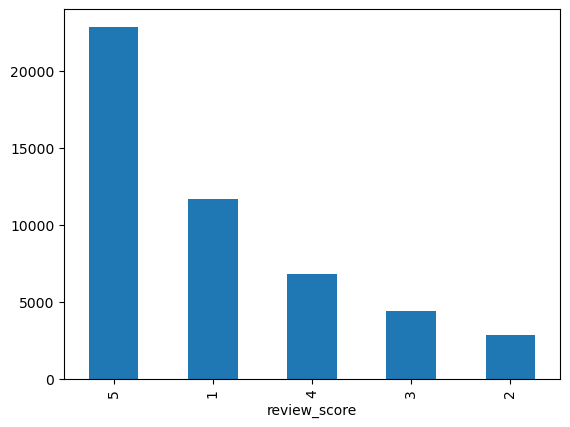

In [13]:
# to display the bar charts by target values
rst = rew_to_score['review_score'].value_counts().plot(kind='bar')

## **Reviews pre-analysis**

In [14]:
rew_to_score = rew_to_score.reset_index().drop(columns="index")

To know exactly which comments are positive and which are negative, it was decided to conduct a small analysis of the comments themselves
since the scores of 1 and 4, 5 are obvious which category they belong to, so I will only look at 2,3

In [15]:
rew_to_score[rew_to_score["review_score"]==2].head(10)

,review_comment_message,review_score
5,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2
67,Demorou de mais pra entrega,2
133,decepcionado,2
157,Foi marcado o dia 14/02 para entrega do pedido...,2
158,LOJA ALÉM DO FRETE SER MUITO CARO . O PRODUTO ...,2
187,A capa protetora não é exatamente o que eu esp...,2
196,O produto foi embalado apenas com papel pardo ...,2
252,comprei o produto na cor preta e chegou na cor...,2
255,Pensei que a mochila fosse um material mais re...,2
272,recebi sim mais com defeito os encaixes sao do...,2


In [16]:
rew_to_score.iloc[158,0]

'LOJA ALÉM DO FRETE SER MUITO CARO . O PRODUTO LEVA QUASE 30 DIAS ÚTEIS , PARA CHEGAR NA SUA CASA'



*   GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU
*   Demorou de mais pra entrega
*   decepcionado
*   Foi marcado o dia 14/02 para entrega do pedido e no rastreamento marcava que o produto já havia sido entregue na data mas na realidade não foi entregue. O produto só foi entregue no dia 28/02.
*   LOJA ALÉM DO FRETE SER MUITO CARO . O PRODUTO LEVA QUASE 30 DIAS ÚTEIS , PARA CHEGAR NA SUA CASA






Demorou de mais pra entrega

translate:

*   I WOULD LIKE TO KNOW WHAT HAPPENED, I HAVE ALWAYS RECEIVED AND THIS PURCHASE
*   Delivery took too long
*   disappointed
*   The order was scheduled for delivery on February 14 and the tracking showed that the product had already been delivered on that date, but in reality it was not. The product was only delivered on 28/02.
*   THE STORE IS VERY EXPENSIVE. THE PRODUCT TAKES ALMOST 30 WORKING DAYS TO ARRIVE AT YOUR HOME





In fact, I have studied and translated many more samples, but only the first 5 have been posted. it was decided that a score of 2 was negative. problems with delivery time, quality of delivery and price are common

Let's see reviews that's has score 3

In [17]:
rew_to_score[rew_to_score["review_score"]==3].head(10)

,review_comment_message,review_score
37,Eu comprei duas unidades e só recebi uma e ago...,3
38,Eu comprei duas unidades e só recebi uma e ago...,3
39,"Produto bom, porém o que veio para mim não con...",3
44,Entrega no prazo,3
45,Entrega no prazo,3
52,"Produto chegou, mas meu PC não conseguiu recon...",3
69,A entrega foi dividida em duas. Não houve comu...,3
72,Gostei,3
100,"Comprei dois lustres pendentes, com a parceira...",3
101,"Comprei dois lustres pendentes, com a parceira...",3


In [18]:
rew_to_score.iloc[101,0]

'Comprei dois lustres pendentes, com a parceira targaryen e só me enviaram um lustre. Abri reclamação, mas ainda não recebi resposta. Aguardo solução por parte de Lojas lannister.'



*   Eu comprei duas unidades e só recebi uma e agora o que faço?
*   Produto bom, porém o que veio para mim não condiz com a foto do anúncio.
*   Entrega no prazo
*   Gostei
*   Comprei dois lustres pendentes, com a parceira targaryen e só me enviaram um lustre. Abri reclamação, mas ainda não recebi resposta. Aguardo solução por parte de Lojas lannister.






translate

*   I bought two units and only received one. What do I do now?
*   Good product, but the one that came to me doesn't match the picture in the ad.
*   On-time delivery
*   I like it
*   I bought two pendant chandeliers from targaryen and they only sent me one. I filed a complaint, but have not received a reply yet. I am waiting for a solution from Lojas lannister.







After deep analysis i desided that data 1,2 - negative, 3 most to positive 4,5 - positive. but let see how think model
and drop dupclicate columns

In [19]:
# Drop duplicated data
rew_to_score_clean = rew_to_score
rew_to_score_clean = rew_to_score_clean.drop_duplicates(subset="review_comment_message")

What's shape before and after?

In [20]:
print(rew_to_score.shape)
print(rew_to_score_clean.shape)

(48592, 2)
(36435, 2)


And what we have now?

In [21]:
rew_to_score_clean.head()

,review_comment_message,review_score
0,Recebi bem antes do prazo estipulado.,5
1,Parabéns lojas lannister adorei comprar pela I...,5
2,aparelho eficiente. no site a marca do aparelh...,4
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4
4,"Vendedor confiável, produto ok e entrega antes...",5


## Pre-view  conclusion

As you can see from the previous analysis, the comments can be really ambiguous about the evaluation, so we will give this task in full for the XGBoost model

# **Data preprocessing**

Our task is to define the comments into positive and negative ones, so after analysis i can label data. where 1 will positive and 0 - negative review

In [22]:
# add column with label data where 1 - positive, 0 - negative
rew_to_score_clean["labels"] = rew_to_score_clean["review_score"].apply(lambda x:
                                                              0 if x==1 else
                                                               (1 if x == 5 else None))

C:\Users\KDFX Modes\AppData\Local\Temp\ipykernel_12280\4267249066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rew_to_score_clean["labels"] = rew_to_score_clean["review_score"].apply(lambda x:


Let's see,what we have now

In [23]:
rew_to_score_clean

,review_comment_message,review_score,labels
0,Recebi bem antes do prazo estipulado.,5,1.0
1,Parabéns lojas lannister adorei comprar pela I...,5,1.0
2,aparelho eficiente. no site a marca do aparelh...,4,NaN
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,NaN
4,"Vendedor confiável, produto ok e entrega antes...",5,1.0
...,...,...,...
48587,Entregou dentro do prazo. O produto chegou em ...,5,1.0
48588,"O produto não foi enviado com NF, não existe v...",3,NaN
48589,"Excelente mochila, entrega super rápida. Super...",5,1.0
48590,Solicitei a compra de uma capa de retrovisor c...,1,0.0


Now, we can check data balance again by labels

In [24]:
label_data = rew_to_score_clean.drop(columns="review_score").dropna(subset=["labels"])

In [25]:
label_data.head()

,review_comment_message,labels
0,Recebi bem antes do prazo estipulado.,1.0
1,Parabéns lojas lannister adorei comprar pela I...,1.0
4,"Vendedor confiável, produto ok e entrega antes...",1.0
6,Péssimo,0.0
7,Loja nota 10,1.0


## Clean reviews by custom funtion

### Function cleaning from emoji, hashtags, filter by chars, removing multi-space

In [26]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [27]:
reviews_new = []
for t in label_data.review_comment_message:
    reviews_new.append(remove_mult_spaces(filter_chars(clean_hashtags \
                                        (strip_all_entities(strip_emoji(t))))))

In [28]:
label_data["review_comment_message"] = reviews_new

In [29]:
label_data["review_comment_message"].head()

0                 recebi bem antes do prazo estipulado
1    parabns lojas lannister adorei comprar pela in...
4    vendedor confivel produto ok e entrega antes d...
6                                               pssimo
7                                         loja nota 10
Name: review_comment_message, dtype: object

## Class Balancing by RandomOverSampler

In [30]:
label_data["labels"].value_counts()

labels
1.0    17434
0.0     8426
Name: count, dtype: int64

As we see data is still unbalanced, so we equal it by RandomOverSampler

In [31]:
label_data.columns

Index(['review_comment_message', 'labels'], dtype='object')

In [32]:
label_data.shape

(25860, 2)

In [33]:
# AutoSampling
ros = RandomOverSampler(random_state=42)
sampled_x, sampled_y = ros.fit_resample(np.array(label_data['review_comment_message'])
                .reshape(-1, 1), np.array(label_data['labels']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in sampled_x],sampled_y)), columns=
                                            ['review_comment_message','labels'])

Check out dataframe

In [34]:
train_os.head(10)

,review_comment_message,labels
0,recebi bem antes do prazo estipulado,1.0
1,parabns lojas lannister adorei comprar pela in...,1.0
2,vendedor confivel produto ok e entrega antes d...,1.0
3,pssimo,0.0
4,loja nota 10,1.0
5,obrigado pela atenao amim dispensada,1.0
6,a compra foi realizada facilmente a entrega fo...,1.0
7,relgio muito bonito e barato,1.0
8,no gostei comprei gato por lebre,0.0
9,sempre compro pela internet e a entrega ocorre...,0.0


Check classes

In [35]:
train_os["labels"].value_counts()

labels
1.0    17434
0.0    17434
Name: count, dtype: int64

Split into train test set's

In [36]:
train, test = train_test_split(train_os,train_size=0.8,test_size=0.2, shuffle=True,
                                                               random_state=42)

test data to validation

In [37]:
train.head()

,review_comment_message,labels
19137,produto com preo acessvel e entrega rapida,1.0
5096,produto entregue antes do prazo e em perfeito ...,1.0
29952,entregou o pedido muito tempo depois e errado ...,0.0
18430,o produto chegou at antes do prazoestou satisf...,1.0
32325,comprei e at agora nada de chegar prazo pro di...,0.0


Convert into dict

In [38]:
train_ = pd.DataFrame(train)
test_ = pd.DataFrame(test)
train_data = Dataset.from_pandas(train_)
test_data = Dataset.from_pandas(test_)

In [39]:
train_data[:3]

{'review_comment_message': ['produto com preo acessvel e entrega rapida',
  'produto entregue antes do prazo e em perfeito estado',
  'entregou o pedido muito tempo depois e errado ainda como se ja no bastasse a dor de cabea de ficar correndo atrs de uma loja incomuicvel ainda tenho a decepo de no receber o que comprei'],
 'labels': [1.0, 1.0, 0.0],
 '__index_level_0__': [19137, 5096, 29952]}

In [40]:
test_data[:3]

{'review_comment_message': ['comprei trs luminrias e recebi somente uma',
  'estou indignada com o descaso efetuei a compra dia 01062017 e ate hoje no recebe meu produto ningum mim ligou para mim esclarecer ou me da satisfao uma vez que ja paguei a 1 parc e vou pagar 2',
  'timo produto entrega antes do previsto certamente procurarei a loja no futuro para outras compras'],
 'labels': [0.0, 0.0, 1.0],
 '__index_level_0__': [34436, 29669, 9946]}

# **Build the model Roberta**

Now, when we done EDA  we can train build model

## Tokenization text

Import the tokenizer used to train the distilbert model. i tried many models, so variable past roberta :)

## tokenization function



In [41]:
roberta_model = ('lxyuan/distilbert-base-multilingual-cased-sentiments-student')

In [42]:
tokenizer = AutoTokenizer.from_pretrained(roberta_model)

D:\miniconda\envs\task_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [43]:
test = "Tokenizing is important for NLP"
tokenized_test = tokenizer(test)
print(tokenized_test)

{'input_ids': [101, 11469, 11062, 39949, 10124, 12452, 10142, 81130, 11127, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [44]:
def tokenize(data):
    return tokenizer(data["review_comment_message"], padding=True, truncation=True, return_tensors="tf")

In [45]:
train_data_encoded = train_data.map(tokenize, batched = True, batch_size = 8)

Map:   0%|          | 0/27894 [00:00<?, ? examples/s]

In [46]:
test_data_encoded = test_data.map(tokenize, batched = True, batch_size = 8)

Map:   0%|          | 0/6974 [00:00<?, ? examples/s]

In [47]:
with tf.device('/CPU:0'):
    roberta = TFAutoModel.from_pretrained(roberta_model, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Feature Extraction

Use hidden states as features. Freeze the body's weights during training.

In [48]:
def extract_hidden_states(batch):
    inputs = tokenizer(batch["review_comment_message"], padding=True,
                       truncation=True, return_tensors='tf')
    outputs = roberta(inputs)
    hidden_states = outputs.last_hidden_state[:, 0].numpy()
    return {"hidden_states": hidden_states}

extracted and saved dataset to avoid long extraction again
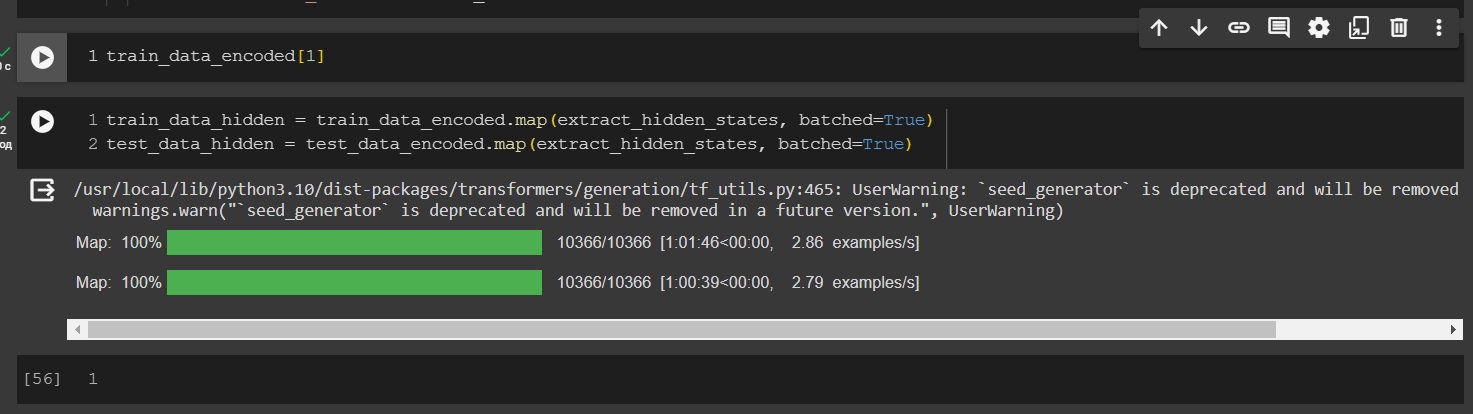

In [51]:
train_data_hidden = train_data_encoded.map(extract_hidden_states, batched=True,batch_size=8)
test_data_hidden = test_data_encoded.map(extract_hidden_states, batched=True,batch_size=8)


INFO:tensorflow:Assets written to: ram://bfbc2227-a168-45b6-a4d4-b81cb7f6b9d0/assets


INFO:tensorflow:Assets written to: ram://bfbc2227-a168-45b6-a4d4-b81cb7f6b9d0/assets


Map:   0%|          | 0/27894 [00:00<?, ? examples/s]

INFO:tensorflow:Assets written to: ram://df1f4845-3f5e-4112-b626-850c71acbbbf/assets


INFO:tensorflow:Assets written to: ram://df1f4845-3f5e-4112-b626-850c71acbbbf/assets


Map:   0%|          | 0/6974 [00:00<?, ? examples/s]

In [52]:
train_path = "D:/Project/SMART_buisness_test_task/Tasks/Task3/Desktop/train"
test_path = "D:/Project/SMART_buisness_test_task/Tasks/Task3/Desktop/test"
pred_path = "D:/Project/SMART_buisness_test_task/Tasks/Task3/Desktop/pred"

In [53]:
train_data_hidden.save_to_disk(train_path)

Saving the dataset (0/1 shards):   0%|          | 0/27894 [00:00<?, ? examples/s]

In [54]:
test_data_hidden.save_to_disk(test_path)

Saving the dataset (0/1 shards):   0%|          | 0/6974 [00:00<?, ? examples/s]

Convert dataset to np.array

In [ ]:
print(train_data_hidden)

In [55]:
X = np.array(train_data_hidden["hidden_states"])
y = np.array(train_data_hidden["labels"])

## Scale data and transfer it to dataframe

In [56]:
X_scaled = MinMaxScaler().fit_transform(X)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["target"] = y
df_emb.head()

,X,Y,target
0,9.394438,5.894917,1.0
1,3.204408,0.131308,1.0
2,-2.390554,1.387457,0.0
3,-3.139509,0.607908,1.0
4,12.439992,-1.534365,0.0


## Training a base Model using the hidden states by XGBoost

In [57]:
from xgboost import XGBClassifier

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

print(y_val)
print(y_train)

[1 1 0 ... 0 0 0]
[0 1 0 ... 1 1 1]


Evaluate

In [60]:
xgb_clf = XGBClassifier()

xgb_clf.fit(X_train, y_train)

xgb_clf.score(X_val, y_val)

0.9507080121885643

In [ ]:
# #Save
# xgb_clf.save_model('0004.model')

## Confusion matrix XGBoost

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix_plot(y_pred, y_true, labels, clf):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    confm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    confm.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title(f"Normalized Confusion Matrix {clf}")
    plt.show()

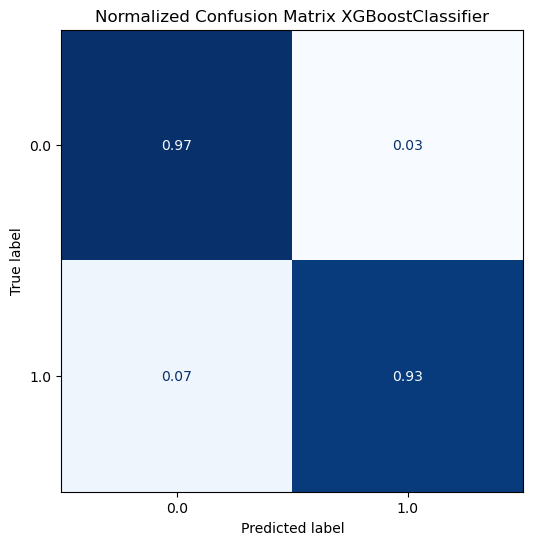

In [62]:
labels = np.unique(y)
y_pred_xgb = xgb_clf.predict(X_val)
confusion_matrix_plot(y_pred_xgb, y_val, labels, "XGBoostClassifier")

# **Predict sentiments to main data**

## Encoding all reviews from data

In [93]:
data_to_predict = merged_data
data_to_predict = data_to_predict.dropna(subset=["review_comment_message"])

In [64]:
pred_reviews_new = []
for t in data_to_predict.review_comment_message:
    pred_reviews_new.append(remove_mult_spaces(filter_chars(clean_hashtags \
                                        (strip_all_entities(strip_emoji(t))))))

In [94]:
data_to_predict["review_comment_message"] = pred_reviews_new
pred = data_to_predict["review_comment_message"]

C:\Users\KDFX Modes\AppData\Local\Temp\ipykernel_12280\2626040748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_predict["review_comment_message"] = pred_reviews_new


In [66]:
pred = pd.DataFrame(pred)
pred = Dataset.from_pandas(pred)

## Encode all data

In [67]:
dred_data_encoded = pred.map(tokenize, batched = True, batch_size = None)

Map:   0%|          | 0/48592 [00:00<?, ? examples/s]

In [69]:
pred_data_hidden = dred_data_encoded.map(extract_hidden_states, batched=True,batch_size=8)

INFO:tensorflow:Assets written to: ram://6e710c9d-12f5-434f-9cff-b2e955c85876/assets


INFO:tensorflow:Assets written to: ram://6e710c9d-12f5-434f-9cff-b2e955c85876/assets


Map:   0%|          | 0/48592 [00:00<?, ? examples/s]

In [70]:
pred_data_hidden.save_to_disk(pred_path)

Saving the dataset (0/1 shards):   0%|          | 0/48592 [00:00<?, ? examples/s]

In [71]:
X_pred = np.array(pred_data_hidden["hidden_states"])

## Predict

**In predicted values 0 - negative review; 1 - positive**

In [72]:
predicted_score = xgb_clf.predict(X_pred)

In [73]:
prd_score = pd.DataFrame(predicted_score)

In [74]:
# prd_score.to_csv("result_score.csv")

## Concatinate data with data predicted by model

In [101]:
data_to_predict["score"] = prd_score

In [99]:
data_to_predict = data_to_predict.reset_index()

## Full review analysis

In [77]:
data_to_predict.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'score'],
      dtype='object')

**Define dataset with just necessary columns**

In [102]:
analysis_rev = data_to_predict[["seller_id", "review_score", "review_comment_message","score"]]

In [103]:
analysis_rev.head(20)

,seller_id,review_score,review_comment_message,score
0,a1043bafd471dff536d0c462352beb48,5,recebi bem antes do prazo estipulado,1
1,989becdce12ebc39863c2bceab6f3ca1,5,parabns lojas lannister adorei comprar pela in...,1
2,05ff92fedb5be47920fea08e501238b9,4,aparelho eficiente no site a marca do aparelho...,1
3,db4350fd57ae30082dec7acbaacc17f9,4,mas um pouco travandopelo valor ta boa,1
4,974cf2cb8f4b7add98709c30df02fe10,5,vendedor confivel produto ok e entrega antes d...,1
5,7ddcbb64b5bc1ef36ca8c151f6ec77df,2,gostaria de saber o que houve sempre recebi e ...,0
6,0be8ff43f22e456b4e0371b2245e4d01,1,pssimo,0
7,8b2492b7ff4468839593fafeed55bad9,5,loja nota 10,1
8,7142540dd4c91e2237acb7e911c4eba2,5,obrigado pela atenao amim dispensada,1
9,c003204e1ab016dfa150abc119207b24,5,a compra foi realizada facilmente a entrega fo...,1


## Let's count values for each score:

In [113]:
print("the score 5 values is:  ", analysis_rev[analysis_rev["review_score"]==5].value_counts("score"),"\n", "-"*30)
print("the score 4 values is:  ", analysis_rev[analysis_rev["review_score"]==4].value_counts("score"),"\n", "-"*30)
print("the score 3 values is:  ", analysis_rev[analysis_rev["review_score"]==3].value_counts("score"),"\n", "-"*30)
print("the score 2 values is:  ", analysis_rev[analysis_rev["review_score"]==2].value_counts("score"),"\n", "-"*30)
print("the score 1 values is:  ", analysis_rev[analysis_rev["review_score"]==1].value_counts("score"),"\n", "-"*30)

the score 5 values is:   score
1    22265
0      577
Name: count, dtype: int64 
 ------------------------------
the score 4 values is:   score
1    5165
0    1628
Name: count, dtype: int64 
 ------------------------------
the score 3 values is:   score
0    2687
1    1739
Name: count, dtype: int64 
 ------------------------------
the score 2 values is:   score
0    2338
1     511
Name: count, dtype: int64 
 ------------------------------
the score 1 values is:   score
0    11462
1      220
Name: count, dtype: int64 
 ------------------------------


## exploring 4 and 3 score

In [116]:
analysis_rev[analysis_rev["review_score"]==4].head(20)

,seller_id,review_score,review_comment_message,score
2,05ff92fedb5be47920fea08e501238b9,4,aparelho eficiente no site a marca do aparelho...,1
3,db4350fd57ae30082dec7acbaacc17f9,4,mas um pouco travandopelo valor ta boa,1
13,bd15ee794d5e640d9dd71b665b2ab15b,4,recebi exatamente o que esperava as demais enc...,1
32,febab0275244b9a49a623f0bd613ca2f,4,tima loja para parceria rpidssima produtos bem...,1
61,0761743cbffb25d7148189e9f1a5f03a,4,estava faltando apenas um produto eu recebi ho...,0
62,0761743cbffb25d7148189e9f1a5f03a,4,estava faltando apenas um produto eu recebi ho...,0
63,0761743cbffb25d7148189e9f1a5f03a,4,estava faltando apenas um produto eu recebi ho...,0
64,0761743cbffb25d7148189e9f1a5f03a,4,estava faltando apenas um produto eu recebi ho...,0
65,0761743cbffb25d7148189e9f1a5f03a,4,estava faltando apenas um produto eu recebi ho...,0
90,1025f0e2d44d7041d6cf58b6550e0bfa,4,se fosse vidro tinha quebrado veio na caixa se...,0


In [118]:
analysis_rev.loc[61, "review_comment_message"]

'estava faltando apenas um produto eu recebi hoje muito obrigada tudo certo att elenice'

translate: only one product was missing i received it today thank you so much everything is fine att elenice 

**It is not surprising why the model identified the comment as negative. one unit of goods did not arrive...**

In [121]:
analysis_rev.loc[135, "review_comment_message"]

'uma das peas no encaixava estava de dimetro diferente eu tive que serrar e martelar para poder caber e encaixar de resto tudo ok'

translate: 'one of the pieces didn't fit, it was a different size, so I had to saw it off and hammer it to get it to fit, otherwise everything was fine'

In [122]:
analysis_rev[analysis_rev["review_score"]==3].head(20)

,seller_id,review_score,review_comment_message,score
37,aac29b1b99776be73c3049939652091d,3,eu comprei duas unidades e s recebi uma e agor...,0
38,aac29b1b99776be73c3049939652091d,3,eu comprei duas unidades e s recebi uma e agor...,0
39,c794dab4928dd97beb41d05514441e86,3,produto bom porm o que veio para mim no condiz...,0
44,78c99c6dff4eeae5be99bf635ed21e3f,3,entrega no prazo,1
45,78c99c6dff4eeae5be99bf635ed21e3f,3,entrega no prazo,1
52,5656537e588803a555b8eb41f07a944b,3,produto chegou mas meu pc no conseguiu reconhe...,0
69,5dceca129747e92ff8ef7a997dc4f8ca,3,a entrega foi dividida em duas no houve comuni...,0
72,7c67e1448b00f6e969d365cea6b010ab,3,gostei,1
100,1025f0e2d44d7041d6cf58b6550e0bfa,3,comprei dois lustres pendentes com a parceira ...,0
101,1025f0e2d44d7041d6cf58b6550e0bfa,3,comprei dois lustres pendentes com a parceira ...,0


In [123]:
analysis_rev.loc[69, "review_comment_message"]

'a entrega foi dividida em duas no houve comunicado do loja cheguei a pensar que s haviam enviado parte do produto'

translate: the delivery was split in two there was no communication from the store i thought they had only sent part of the product

## Drop review duplicates and explore correlation

In [125]:
analysis_dropped = analysis_rev.drop_duplicates(subset="review_comment_message")

In [127]:
print("the score 5 values is:  ", analysis_dropped[analysis_dropped["review_score"]==5].value_counts("score"),"\n", "-"*30)
print("the score 4 values is:  ", analysis_dropped[analysis_dropped["review_score"]==4].value_counts("score"),"\n", "-"*30)
print("the score 3 values is:  ", analysis_dropped[analysis_dropped["review_score"]==3].value_counts("score"),"\n", "-"*30)
print("the score 2 values is:  ", analysis_dropped[analysis_dropped["review_score"]==2].value_counts("score"),"\n", "-"*30)
print("the score 1 values is:  ", analysis_dropped[analysis_dropped["review_score"]==1].value_counts("score"),"\n", "-"*30)

the score 5 values is:   score
1    15339
0      439
Name: count, dtype: int64 
 ------------------------------
the score 4 values is:   score
1    3417
0    1316
Name: count, dtype: int64 
 ------------------------------
the score 3 values is:   score
0    2021
1    1220
Name: count, dtype: int64 
 ------------------------------
the score 2 values is:   score
0    1670
1     383
Name: count, dtype: int64 
 ------------------------------
the score 1 values is:   score
0    8044
1     141
Name: count, dtype: int64 
 ------------------------------


**Now we can conclude that the score of 4 is more positive than negative, the scores of 3 and 2 are more negative than positive**

## Looking for seller with just negative reviews

In [172]:
negative_sellers = analysis_rev[["seller_id", "score"]]

In [186]:
neg_seller = negative_sellers[negative_sellers.groupby("seller_id")["score"].transform('sum') == 0]

In [190]:
neg_seller.value_counts()

seller_id                         score
4342d4b2ba6b161468c63a7e7cfce593  0        16
973f21788dfab357250f69a8dcb7ddee  0        12
f63d8f293af3a6454377546bd9dd19ff  0         9
02d35243ea2e497335cd0f076b45675d  0         8
bc503e244f187939d10c92a5c8e378ce  0         8
                                           ..
6614814a00d344b846ae209f95ee7e3f  0         1
6601ee6383e7f452be71929f8de48bbb  0         1
651530bf5c607240ccdd89a30c9c9712  0         1
63bc58679c44e8a998792119fd7ad23e  0         1
ffcfefa19b08742c5d315f2791395ee5  0         1
Name: count, Length: 365, dtype: int64

In [193]:
neg_seller = neg_seller.groupby("seller_id").sum().reset_index()

In [194]:
neg_seller

,seller_id,score
0,0015a82c2db000af6aaaf3ae2ecb0532,0
1,001e6ad469a905060d959994f1b41e4f,0
2,010da0602d7774602cd1b3f5fb7b709e,0
3,02a2272692e13558373c66db98f05e2e,0
4,02d35243ea2e497335cd0f076b45675d,0
...,...,...
360,fcf16b7a8697e559f0123190bb30177d,0
361,fec6912baad85d41729669edd6b4d3b8,0
362,fedf2c1386e137f296b3bbf3b635e69d,0
363,ff82e8873fba613f2261a9acc896fd84,0


**Now we have dataframe with seller, who has just negative scores.**

# Definition of the essence of price

I translated price, high, much, expensive to portuguese and found synonyms and map them by regex. every raw in data frame that contain words will add to df

In [ ]:
rew_to_score_clean.columns

In [ ]:
# Load the original dataset
df = rew_to_score_clean

# Create a new dataset
new_df = pd.DataFrame(columns=['review_comment_message'])

# List of words to search using regular expressions
search_words = ['Valor', 'Tarifa', 'Custo', 'Exorbitante', 'Elevado',
                'Proibitivo', 'Bastante', 'Considerável', 'Abundante',
                'Oneroso', 'Custoso', 'Dispendioso']

# Iterate over each search word
for word in search_words:
    # Perform search using regular expression
    regex = r'\b' + word + r'\b'
    matches = df['review_comment_message'].str.contains(regex, regex=True,
                                                               case=False)

    # Add matches to the new dataset
    matches_df = df[matches]
    new_df = pd.concat([new_df, matches_df['review_comment_message']],
                                                        ignore_index=True)

new_df = new_df.rename(columns={0:"reviews with price"})\
                            .drop(columns="review_comment_message",axis=1)

In [ ]:
new_df

In [ ]:
new_df.iloc[4,0]

translate: The product was not as advertised. I called and I'm just waiting for the code to return the product and refund the amount paid.

In [ ]:
new_df.iloc[500,0]

translate Quality product with great value for money

In [ ]:
new_df.iloc[200,0]

translate: I paid shipping and had to pick up the product. Not to mention that the shipping was expensive. It took a long time to arrive.
I just think the shipping should be cheaper. Shipping ends up being the same as the product or more expensive.

Conclusion. this method works, if buisness will need and department will want to define reviews with price with better accuracy we can improve by creating synthethic dataset from our data, and after train model...

# **Task conclusion**

**In this assignment, I had to determine the positive and negative reviews using feature raising and XGBoost. I chose XGBoost because it is lightweight, fast to train, does not have many hyperparameters, and as a result performed quite well. 
Since the model was trained on scores 1 and 5, there were some inaccuracies with sentences such as did not come or was broken, although the score itself was positive. In the future, I would recommend training the dataset on all grades and define grade 3 depending on the needs of the business.  
The correlation of comments on the assessment follows the logic: 4 and 5 are more positive, 1, 2, 3 are less. 
We found more than 300 sellers who had only negative reviews and created a table. 
And a function was created to determine the essence of price for the financial department. Improvements could also be made to the price if it was not enough. Namely, to create a sentimental dataset based on the filtered data and train the model on it.**